<a href="https://colab.research.google.com/github/mattialeonessi/progetto-DIA/blob/master/tossicit%C3%A0pesci.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***PREVISIONE TOSSICITÀ ACQUATICA ACUTA QUANTITATIVA NEI CONFRONTI DEL PESCE Pimephales promelas***
Programmazione di Applicazioni Data Intensive
Laurea in Ingegneria e Scienze Informatiche
DISI - Università di Bologna, Cesena

Mattia Leonessi

Citazioni

*   M. Cassotti, D. Ballabio, R. Todeschini, V. Consonni. A similarity-based QSAR model for predicting acute toxicity towards the fathead minnow (Pimephales promelas), SAR and QSAR in Environmental Research (2015), 26, 217-243; doi: 10.1080/1062936X.2015.1018938




# ***Descrizione del problema e comprensione dei dati***

Questo set di dati è stato utilizzato per sviluppare modelli QSAR di regressione quantitativa per prevedere la tossicità acquatica acuta nei confronti dei pesci Pimephales promelas.


 Carichiamo le librerie per effettuare operazioni sui dati:


*   numpy per creare e operare su array a N dimensioni
*   pandas per caricare e manipolare dati tabulari
*   matplotlib per creare grafici

Importiamo le librerie usando i loro alias convenzionali e abilitando l'inserimento dei grafici direttamente nel notebook








In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Carichiamo il dataset ottenuto da [UCI](https://archive.ics.uci.edu/ml/datasets/QSAR+fish+toxicity).

***Significato delle feature***

Il dataset contiene 7 variabili, 6 indipendenti e 1 dipendente:


1.   CIC0: indici di informazione
2.   SM1_DZ: descrittori di base
3.   GATS1i: autocorrelazioni 2D
4.   NdsCH: conteggi di tipo atomico
5.   NdssC: conteggi di tipo atomico
6.   MLOGP: proprietà molecolari

la variabile dipendente da predire è:

7.   LC50: concentrazione che provoca la morte nel 50% dei pesci test

Sono raccolte 908 osservazioni, non ci sono valori nulli.









In [ ]:
import os.path
if not os.path.exists("fish_toxicity.csv"):
    from urllib.request import urlretrieve
    urlretrieve("https://archive.ics.uci.edu/ml/machine-learning-databases/00504/qsar_fish_toxicity.csv", 
                "fish_toxicity.csv")

In [ ]:
data = pd.read_csv("fish_toxicity.csv", header=None, sep=";")
data.columns = "CIC0 SM1_Dz GATS1i NdsCH NdssC MLOGP LC50".split()
data.shape

(908, 7)

In [ ]:
data.head(5)

,CIC0,SM1_Dz,GATS1i,NdsCH,NdssC,MLOGP,LC50
0,3.260,0.829,1.676,0,1,1.453,3.770
1,2.189,0.580,0.863,0,0,1.348,3.115
2,2.125,0.638,0.831,0,0,1.348,3.531
3,3.027,0.331,1.472,1,0,1.807,3.510
4,2.094,0.827,0.860,0,0,1.886,5.390


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 908 entries, 0 to 907
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CIC0    908 non-null    float64
 1   SM1_Dz  908 non-null    float64
 2   GATS1i  908 non-null    float64
 3   NdsCH   908 non-null    int64  
 4   NdssC   908 non-null    int64  
 5   MLOGP   908 non-null    float64
 6   LC50    908 non-null    float64
dtypes: float64(5), int64(2)
memory usage: 49.8 KB


# ***Analisi esplorativa dei dati***

In [ ]:
for x in ["CIC0", "SM1_Dz", "GATS1i", "NdsCH", "NdssC", "MLOGP", "LC50"]:
    print(x+":\t"+ str(data[x].nunique()));

CIC0:	502
SM1_Dz:	186
GATS1i:	557
NdsCH:	5
NdssC:	7
MLOGP:	559
LC50:	827


Notiamo che la maggior parte delle feature contengono valori distinti, seppur in un range molto ristretto di valori, infatti hanno una deviazione standard relativamente bassa.

Con il metodo _describe_ è possibile avere una rappresentazione statistica delle feature numeriche, ottenendo media, deviazione standard e la distribuzione in termini di massimi, minimi e percentili.

In [ ]:
data.describe()

,CIC0,SM1_Dz,GATS1i,NdsCH,NdssC,MLOGP,LC50
count,908.000000,908.000000,908.000000,908.000000,908.000000,908.000000,908.000000
mean,2.898129,0.628468,1.293591,0.229075,0.485683,2.109285,4.064431
std,0.756088,0.428459,0.394303,0.605335,0.861279,1.433181,1.455698
min,0.667000,0.000000,0.396000,0.000000,0.000000,-2.884000,0.053000
25%,2.347000,0.223000,0.950750,0.000000,0.000000,1.209000,3.151750
50%,2.934000,0.570000,1.240500,0.000000,0.000000,2.127000,3.987500
75%,3.407000,0.892750,1.562250,0.000000,1.000000,3.105000,4.907500
max,5.926000,2.171000,2.920000,4.000000,6.000000,6.515000,9.612000


Come ci si poteva aspettare dalla deviazione standard, la maggior parte dei valori non si discosta molto dalla media:

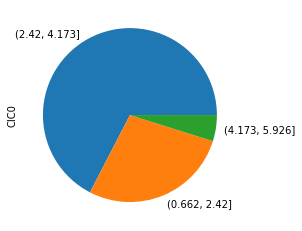

In [ ]:
pd.cut(data["CIC0"], 3).value_counts().plot.pie()

Il seguente boxplot visualizza le statistiche di base delle serie del dataframe, fornisce sostanzialmente molte delle informazioni fornite dal metodo describe ma in modo visivo:

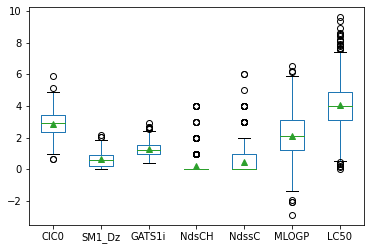

In [ ]:
data.plot.box(showmeans=True)

Cerchiamo, attraverso i seguenti grafici a dispersione, di valutare se esiste una correlazione tra due variabili. Il primo grafico evidenzia che tendenzialmente i valori di LC50 sono tanto più bassi quanto più alti sono quelli di GATS1i, mentre dal secondo si evince che i valori di LC50 si alzano all'aumentare del valore della variabile indipendente MLOGP.

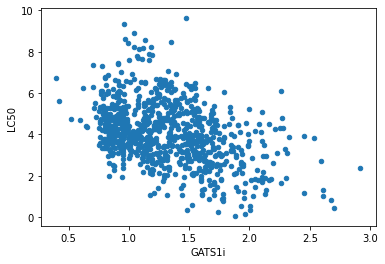

In [ ]:
data.plot.scatter("GATS1i", "LC50")

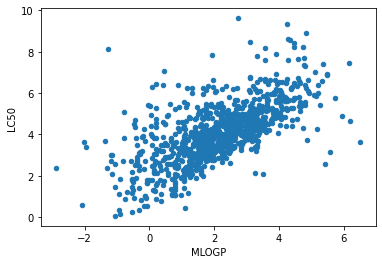

In [ ]:
data.plot.scatter("MLOGP", "LC50")

Per quantificare la correlazione, possiamo calcolare il coefficiente di correlazione di Pearson.
Valori vicini a 1 indicano correlazione diretta (Y cresce al crescere di X) mentre valori vicini a -1 indicano correlazione inversa (Y descresce al crescere di X).

In [ ]:
lc50 = data["LC50"].values
mlogp = data["MLOGP"].values
gats1i = data["GATS1i"].values

np.mean((mlogp-mlogp.mean()) * (lc50-lc50.mean())) / (mlogp.std() * lc50.std())

0.6516640291894156

In [ ]:
np.mean((gats1i-gats1i.mean()) * (lc50-lc50.mean())) / (gats1i.std() * lc50.std())

-0.39796469174961596

I valori ottenuti confermano che esiste una correlazione diretta tra le variabili lc50 e mlogp, mentre esiste una correlazione (più debole) inversa tra lc50 e gats1i.

# ***Preparazione e creazione del modello***
Andiamo ora a testare alcune tecniche di regressione per valutare quella che meglio si presta al tipo di problema. 

Definiamo una funzione che valuti l'accuratezza del modello secondo il calcolo del MSE, errore relativo e coefficiente r². 
Per verificare che il modello generalizzi correttamente i dati su cui è addestrato, utilizziamo il metodo hold-hout per effettuare una divisione in training e validation set.

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

def relative_error(y, y_pred):
    return np.mean(np.abs((y - y_pred) / y))
def print_eval(X, y, model):
    print("Mean squared error: {:.5}".format(mean_squared_error(model.predict(X), y)))
    print("Relative error: {:.5%}".format(relative_error(model.predict(X), y)))
    print("R-squared coefficient: {:.5}".format(model.score(X, y)))

In [ ]:
#hold-out validation
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    data.drop("LC50", axis=1), 
    data["LC50"], 
    test_size=1/3, random_state=42
)

***REGRESSIONE LINEARE***

Iniziamo con un semplice modello di regressione lineare sfruttando la libreria scikit learn, visualizziamone l'accuratezza tramite le misure d'errore e i coefficienti dei parametri ottenuti, per dedurre il peso che ciascuna variabile ha nella predizione.

In [ ]:

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

model1 = Pipeline([
       ("linreg", LinearRegression())
])
model1.fit(X_train, y_train)
print_eval(X_val, y_val, model1)

Mean squared error: 0.923
Relative error: 19.15832%
R-squared coefficient: 0.56628


In [ ]:
pd.Series(model1.named_steps["linreg"].coef_, X_train.columns)

CIC0      0.453563
SM1_Dz    1.311278
GATS1i   -0.670172
NdsCH     0.354748
NdssC     0.037094
MLOGP     0.380334
dtype: float64

***REGRESSIONE LINEARE CON STANDARDIZZAZIONE***

Aggiungiamo al modello la standardizzazione. Non siamo in presenza di variabili con scale molto diverse, per cui non ci aspettiamo risultati molto differenti rispetto al modello senza standardizzazione.

In [ ]:
from sklearn.preprocessing import StandardScaler

model2 = Pipeline([
    ("scale", StandardScaler()),
    ("linreg", LinearRegression())
])

model2.fit(X_train, y_train)
print_eval(X_val, y_val, model2)

Mean squared error: 0.923
Relative error: 19.15832%
R-squared coefficient: 0.56628


***REGRESSIONE POLINOMIALE***

Aggiungiamo alla pipeline il filtro per addestrare un modello polinomiale di secondo grado: otteniamo un modello leggermente più accurato.

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

model3 = Pipeline([
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("scale", StandardScaler()),
    ("linreg", LinearRegression())
])
model3.fit(X_train, y_train)
print_eval(X_val, y_val, model3)

Mean squared error: 0.90773
Relative error: 17.42790%
R-squared coefficient: 0.57345


***REGRESSIONE RIDGE***

Aggiungiamo ora la regolarizzazione Ridge, che modifica la funzione d'errore su cui si basa l'addestramento aggiungendo una penalità per valori estremi dei parametri del modello. L'iperparametro alpha determina il peso generale della regolarizzazione.

Utilizziamo la grid search per individuare i migliori iperparametri che massimizzino l'accuratezza del modello. Creiamo la griglia dei parametri, ovvero un dizionario in cui associamo ai nomi
dei parametri variabili i valori che possono assumere. Per ogni valore possibile, scikit learn esegue la cross validation per calcolare il coefficiente r² medio del modello.

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

model4 = Pipeline([
    ("poly", PolynomialFeatures(include_bias=False)),
    ("scale", StandardScaler()),
    ("regr", Ridge())
])

grid = {
"poly__degree": [2, 3, 4, 5], # <- grado polinomio
"regr__alpha": [0.1, 0.5, 1] # <- regolarizzazione
}
gs = GridSearchCV(model4, param_grid=grid, cv=5)
gs.fit(X_train, y_train)
gs.best_params_

{'poly__degree': 2, 'regr__alpha': 1}

Implementiamo il modello utilizzando gli iperparametri trovati dalla grid search.

In [ ]:
model4 = Pipeline([
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("scale", StandardScaler()),
    ("regr", Ridge(alpha=1))
])
%time model4.fit(X_train, y_train);
print_eval(X_val, y_val, model4)

CPU times: user 5.91 ms, sys: 4.03 ms, total: 9.93 ms
Wall time: 4.99 ms
Mean squared error: 0.8954
Relative error: 17.36782%
R-squared coefficient: 0.57925


***REGRESSIONE LASSO***

Proviamo ora la regolarizzazione Lasso, per verificare la presenza di variabili meno rilevanti. Il modello è già abbastanza semplice, per cui non ci aspettiamo grossi vantaggi, può essere utile comunque per capire quali siano le variabili più influenti.

In [ ]:
from sklearn.linear_model import Lasso

model5 = Pipeline([
    ("scale", StandardScaler()),
    ("regr", Lasso())
])
grid = {
"regr__alpha": [0.1, 0.5, 1] 
}
gs = GridSearchCV(model5, param_grid=grid, cv=5)
gs.fit(X_train, y_train)
gs.best_params_

{'regr__alpha': 0.1}

In [ ]:
model5 = Pipeline([
    ("scale",  StandardScaler()),
    ("linreg", Lasso(alpha=0.1))
])
model5.fit(X_train, y_train);
print_eval(X_val, y_val, model5)

Mean squared error: 0.98697
Relative error: 19.61576%
R-squared coefficient: 0.53622


In [ ]:
pd.Series(model5.named_steps["linreg"].coef_, X_train.columns)

CIC0      0.156985
SM1_Dz    0.420364
GATS1i   -0.131987
NdsCH     0.113158
NdssC     0.006743
MLOGP     0.614085
dtype: float64

***REGRESSIONE ELASTIC NET***

La regressione Elastic Net combina insieme regressione Ridge e Lasso. In aggiunta all'iperparametro alpha, c'è anche l1_ratio, che determina il peso della regolarizzazione l1 rispetto al totale: con l1 = 0 avremo una regressione ridge, con l1 = 1 una regressione lasso.

In [ ]:
from sklearn.linear_model import ElasticNet

model6 = Pipeline([
    ("poly", PolynomialFeatures(include_bias=False)),
    ("scale", StandardScaler()),
    ("linreg", ElasticNet())
]) 

grid = {
"poly__degree": [2, 3], 
"linreg__alpha": [0.1, 0.5, 1], 
"linreg__l1_ratio": [0.01, 0.05, 0.1]
}
gs = GridSearchCV(model6, param_grid=grid, cv=5)
gs.fit(X_train, y_train)
print_eval(X_val, y_val, gs)

Mean squared error: 0.89838
Relative error: 17.36752%
R-squared coefficient: 0.57785


In [ ]:
gs.best_params_

{'linreg__alpha': 0.1, 'linreg__l1_ratio': 0.01, 'poly__degree': 3}

Il valore di l1_ratio stabilito migliore è praticamente nullo, ciò significa che una regolarizzazione lasso non è utile per ottenere un'accuratezza migliore e conferma quanto visto nei modelli precedenti.

***REGRESSIONE CON FUNZIONE KERNEL***

Le funzioni kernel permettono di ottenere modelli non lineari senza l'aggiunta di nuove variabili. Utilizziamo la classe KernelRidge che implementa la regressione ridge con l'applicazione di una funzione kernel.

In [ ]:
from sklearn.kernel_ridge import KernelRidge

model7 = Pipeline([
    ("scale", StandardScaler()),
    ("reg", KernelRidge(alpha=20, kernel="poly", degree=2))
]) 
%time model7.fit(X_train, y_train)
print_eval(X_val, y_val, model7)

CPU times: user 24.1 ms, sys: 12.9 ms, total: 37 ms
Wall time: 20.3 ms
Mean squared error: 0.88764
Relative error: 17.89458%
R-squared coefficient: 0.58289


Un'alternativa al metodo di validazione hold-out è k-fold: i dati sono divisi casualmente in k gruppi, ciascun gruppo è validato su un modello addestrato su tutti gli altri gruppi. Applichiamo questo metodo al modello migliore ottenuto fino ad ora, creando 5 fold. La funzione cross_val_score restituisce il coefficiente r² per ciascun gruppo, ne calcoliamo media e deviazione standard.

In [ ]:
#kfold 

X = data.drop(["LC50"], axis=1)
y = data["LC50"]

from sklearn.model_selection import KFold
kf = KFold(5, shuffle=True, random_state=42)

from sklearn.model_selection import cross_val_score
scores = cross_val_score(model7, X, y, cv=kf)
scores

array([0.61492634, 0.39278407, 0.53019918, 0.64576453, 0.61417471])

In [ ]:

scores.mean(), scores.std()

(0.5595697671429981, 0.09182122545160376)

Sebbene alcuni gruppi abbiano un coefficiente r² migliore, la media è leggermente inferiore rispetto al valore ottenuto con hold-out.

#***Confronto dei modelli***
L'accuratezza ci dà un'indicazione di quanto il modello sia efficace nella previsione, ma tale valore è comunque una stima che dipende anche dal validation set usato. Fissiamo un livello di confidenza del 95%, ovvero una percentuale di certezza che vogliamo avere. 

Vogliamo individuare l'intervallo di confidenza, cioè l'intervallo di valori in cui l'accuratezza "reale" del modello si trova col 95\% di probabilità.

La funzione diff_interval calcola l'intervallo di confidenza della differenza di accuratezza tra due modelli.
La funzione model_conf_interval restituisce tale intervallo.


In [ ]:
from scipy.stats import norm

def diff_interval(a1, a2, N1, N2, Z):
    d = abs(a1 - a2)
    sd = np.sqrt(a1 * (1-a1) / N1 + a2 * (1-a2) / N2)
    return d - Z * sd, d + Z * sd

def model_diff_interval(m1, m2, X, y, level=0.95):
    a1 = m1.score(X, y)
    a2 = m2.score(X, y)
    N = len(X)
    Z = norm.ppf((1 + level) / 2)
    return diff_interval(a1, a2, N, N, Z)

model_diff_interval(model4, model7, X_val, y_val)

(-0.07491976021354732, 0.0822082915374375)

L'intervallo include lo 0, per cui la differenza tra le accuratezze non è significativa: il modello con accuratezza più alta non è effettivamente migliore.




# ***Reti neurali***

Proviamo ora con le reti neurali, sfruttando la libreria keras.

In [ ]:
!pip install tensorflow

In [ ]:
import tensorflow as tf

In [ ]:
scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_val = scaler_X.transform(X_val)

scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train[:, None]).ravel()
y_val = scaler_y.transform(y_val[:, None]).ravel()

Creiamo inizialmente un modello Sequential contenente un unico strato e un unico nodo, che riceve in input le 6 variabili indipendenti e restituisce l'output della rete. Quando compiliamo la rete specifichiamo l'algoritmo di ottimizzazione e la misura di errore da minimizzare, in questo caso l'errore quadratico medio.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model10 = Sequential([
    Dense(1, input_dim=6)
])
model10.compile(optimizer="adam", loss="mean_squared_error")
model10.fit(X_train, y_train, batch_size=3, epochs=10)
model10.evaluate(X_val, y_val)


Epoch 1/10
202/202 [==============================] - 0s 951us/step - loss: 2.0301
Epoch 2/10
202/202 [==============================] - 0s 971us/step - loss: 1.4898
Epoch 3/10
202/202 [==============================] - 0s 962us/step - loss: 1.1217
Epoch 4/10
202/202 [==============================] - 0s 1ms/step - loss: 0.8795
Epoch 5/10
202/202 [==============================] - 0s 919us/step - loss: 0.7267
Epoch 6/10
202/202 [==============================] - 0s 952us/step - loss: 0.6310
Epoch 7/10
202/202 [==============================] - 0s 932us/step - loss: 0.5738
Epoch 8/10
202/202 [==============================] - 0s 907us/step - loss: 0.5380
Epoch 9/10
202/202 [==============================] - 0s 970us/step - loss: 0.5148
Epoch 10/10
10/10 [==============================] - 0s 1ms/step - loss: 0.5500


0.5500054359436035

In [ ]:
r2_score(y_val, model10.predict(X_val))

0.45474742595222006

Abbiamo migliorato MSE ma peggiorato il coefficiente r² rispetto al modello migliore con le funzioni kernel. Proviamo ad aggiungere uno strato e una funzione di attivazione di tipo sigmoide. Avremo così un modello sequenziale composto da due strati di tipo Dense.

In [ ]:
model12 = Sequential([
    Dense(16, activation="sigmoid", input_dim=6),
    Dense(1)
])
model12.compile(optimizer="adam", loss="mean_squared_error")
model12.fit(X_train, y_train, batch_size=3, epochs=10)
model12.evaluate(X_val, y_val)

Epoch 1/10
202/202 [==============================] - 0s 1ms/step - loss: 0.9665
Epoch 2/10
202/202 [==============================] - 0s 1ms/step - loss: 0.5890
Epoch 3/10
202/202 [==============================] - 0s 962us/step - loss: 0.4617
Epoch 4/10
202/202 [==============================] - 0s 1ms/step - loss: 0.4251
Epoch 5/10
202/202 [==============================] - 0s 995us/step - loss: 0.4146
Epoch 6/10
202/202 [==============================] - 0s 1ms/step - loss: 0.4122
Epoch 7/10
202/202 [==============================] - 0s 1ms/step - loss: 0.4098
Epoch 8/10
202/202 [==============================] - 0s 994us/step - loss: 0.4093
Epoch 9/10
202/202 [==============================] - 0s 995us/step - loss: 0.4067
Epoch 10/10
10/10 [==============================] - 0s 1ms/step - loss: 0.4239


0.423892080783844

In [ ]:
r2_score(y_val, model12.predict(X_val))

0.5797710180970848

Abbiamo ottenuto un modello più accurato, proviamo ora a cambiare funzione d'attivazione.

In [ ]:
model13 = Sequential([
    Dense(16, activation="relu", input_dim=6),
    Dense(1)
])
model13.compile(optimizer="adam", loss="mean_squared_error")
model13.fit(X_train, y_train, batch_size=3, epochs=10)
model13.evaluate(X_val, y_val)

Epoch 1/10
202/202 [==============================] - 0s 1ms/step - loss: 0.8770
Epoch 2/10
202/202 [==============================] - 0s 1ms/step - loss: 0.5060
Epoch 3/10
202/202 [==============================] - 0s 1ms/step - loss: 0.4322
Epoch 4/10
202/202 [==============================] - 0s 985us/step - loss: 0.4135
Epoch 5/10
202/202 [==============================] - 0s 1ms/step - loss: 0.4093
Epoch 6/10
202/202 [==============================] - 0s 983us/step - loss: 0.4009
Epoch 7/10
202/202 [==============================] - 0s 974us/step - loss: 0.3945
Epoch 8/10
202/202 [==============================] - 0s 1ms/step - loss: 0.3920
Epoch 9/10
202/202 [==============================] - 0s 993us/step - loss: 0.3889
Epoch 10/10
10/10 [==============================] - 0s 2ms/step - loss: 0.4122


0.4122079908847809

In [ ]:
r2_score(y_val, model13.predict(X_val))

0.5913541315777142

Vediamo se riusciamo a migliorarlo ulteriormente aggiungendo altri strati.

In [ ]:
model14 = Sequential([
    Dense(512, activation="relu", input_dim=6),
    Dense(128, activation="relu"),
    Dense(32, activation="relu"),
    Dense(1)
])
model14.compile(optimizer="adam", loss="mean_squared_error")
fit_history = model14.fit(X_train, y_train, batch_size=100, epochs=10)
model14.evaluate(X_val, y_val)

Epoch 1/10
7/7 [==============================] - 0s 3ms/step - loss: 0.7804
Epoch 2/10
7/7 [==============================] - 0s 4ms/step - loss: 0.4501
Epoch 3/10
7/7 [==============================] - 0s 3ms/step - loss: 0.4316
Epoch 4/10
7/7 [==============================] - 0s 3ms/step - loss: 0.3831
Epoch 5/10
7/7 [==============================] - 0s 3ms/step - loss: 0.3880
Epoch 6/10
7/7 [==============================] - 0s 3ms/step - loss: 0.3845
Epoch 7/10
7/7 [==============================] - 0s 4ms/step - loss: 0.3648
Epoch 8/10
7/7 [==============================] - 0s 3ms/step - loss: 0.3480
Epoch 9/10
7/7 [==============================] - 0s 3ms/step - loss: 0.3408
Epoch 10/10
10/10 [==============================] - 0s 1ms/step - loss: 0.4030


0.4029543399810791

In [ ]:


r2_score(y_val, model14.predict(X_val))

0.6005277482099192